In [61]:
!pip install tensorflow

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/HistoricalData_1717138717541.csv')

data.head()

,Date,Close/Last,Open,High,Low
0,05/30/2024,10205.24,10332.57,10348.39,10174.34
1,05/29/2024,10396.40,10386.55,10451.02,10386.55
2,05/28/2024,10526.85,10592.65,10594.29,10462.57
3,05/24/2024,10549.22,10494.50,10616.85,10480.60
4,05/23/2024,10495.82,10698.18,10704.39,10444.49


In [65]:
data.drop(columns=['Open', 'High', 'Low'], inplace=True)

In [66]:
data = data.set_index('Date')
data = data.iloc[::-1]
# data = data.loc['10/30/2023':'5/29/2024']

data

,Close/Last
Date,
05/31/2019,4237.28
06/03/2019,4170.02
06/04/2019,4320.98
06/05/2019,4329.21
06/06/2019,4375.45
...,...
05/23/2024,10495.82
05/24/2024,10549.22
05/28/2024,10526.85


In [67]:
data.reset_index(inplace = False)
data

,Close/Last
Date,
05/31/2019,4237.28
06/03/2019,4170.02
06/04/2019,4320.98
06/05/2019,4329.21
06/06/2019,4375.45
...,...
05/23/2024,10495.82
05/24/2024,10549.22
05/28/2024,10526.85


In [68]:
# Kiểm tra giá trị thiếu
data.isnull().sum()


Close/Last    0
dtype: int64

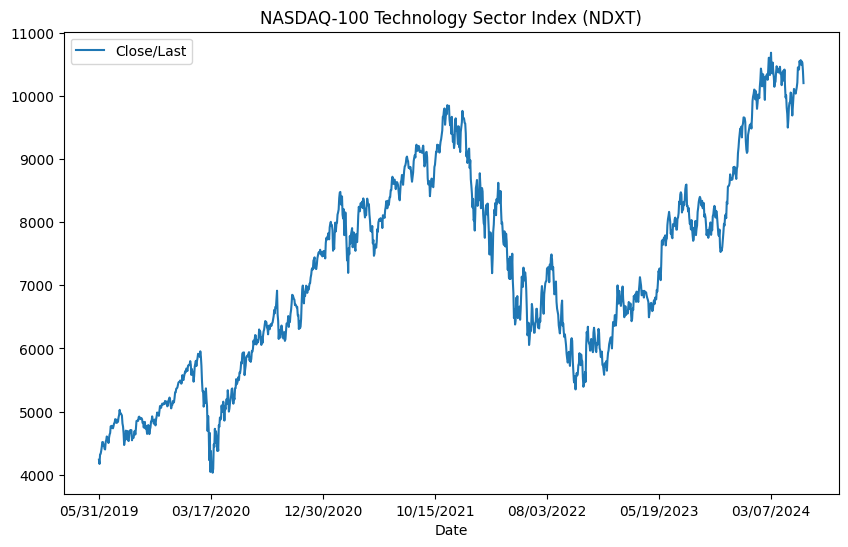

In [69]:
# Vẽ biểu đồ dữ liệu thời gian
data.plot(figsize=(10, 6))
plt.title('NASDAQ-100 Technology Sector Index (NDXT)')
plt.show()

Tiền xử lý dữ liệu

In [70]:
import torch
from sklearn.preprocessing import MinMaxScaler

In [71]:
seq_length = 30
num_predict = 1

In [72]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = int(len(data) * 0.1)
data_test_pre = data.iloc[train_size + val_size:]

In [73]:
def sliding_windows(data, seq_length, num_predict=1):
    x = []
    y = []

    for i in range(data.shape[0]-seq_length-num_predict):
        _x = data[i:(i+seq_length), :] # shape (seq_length, num_symbols)
        _y = data[(i+seq_length):(i+seq_length+num_predict), :][0] # shape (num_symbols,)
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# X_pre, y_pre = sliding_windows(data, seq_length=seq_length, num_predict=num_predict)
# train_size = int(len(y_pre) * 0.8)
# val_size = int(len(y_pre) * 0.1)
# test_size = int(len(y_pre) * 0.1)
# data_test = data.iloc[train_size + val_size:]

# Scaling dataset
sc = MinMaxScaler(feature_range=(-1, 1))
training_data = sc.fit_transform(data)
X, y = sliding_windows(training_data, seq_length=seq_length, num_predict=num_predict)

print(X.shape, y.shape)

(1228, 30, 1) (1228, 1)


In [74]:
# Train/test split
train_size = int(len(y) * 0.8)
val_size = int(len(y) * 0.1)
test_size = int(len(y) * 0.1)

data_test = data.iloc[train_size + val_size:]


trainX = np.array(X[:train_size])
trainY = np.array(y[:train_size])

valX = np.array(X[train_size:train_size + val_size])
valY = np.array(y[train_size:train_size + val_size])

testX = np.array(X[train_size + val_size:])
testY = np.array(y[train_size + val_size:])

print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)

(982, 30, 1) (122, 30, 1) (124, 30, 1)
(982, 1) (122, 1) (124, 1)


In [75]:
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(50),
    Dense(128),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(valX, valY), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 1))), axis=1))[:,0]

Epoch 1/30
16/16 [==============================] - 4s 55ms/step - loss: 0.0495 - val_loss: 0.0050
Epoch 2/30
16/16 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 3/30
16/16 [==============================] - 0s 20ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 4/30
16/16 [==============================] - 0s 22ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/30
16/16 [==============================] - 0s 20ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/30
16/16 [==============================] - 1s 42ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/30
16/16 [==============================] - 1s 47ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/30
16/16 [==============================] - 1s 32ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/30
16/16 [==============================] - 1s 56ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 10/30
16/16 [==============================] - 1s 62ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/

In [76]:
data_test['Close/Last'].values[seq_length+1:]

array([ 8878.94,  8767.82,  8749.09,  8686.94,  8847.  ,  8887.07,
        9095.48,  9184.73,  9311.25,  9404.68,  9483.86,  9475.25,
        9514.86,  9344.42,  9523.19,  9566.56,  9661.82,  9660.16,
        9650.4 ,  9587.92,  9286.98,  9152.49,  9098.91,  9122.27,
        9382.04,  9431.27,  9488.72,  9539.06,  9534.17,  9562.14,
        9485.01,  9658.97,  9921.77,  9994.6 , 10035.03, 10103.12,
       10092.35,  9947.71, 10077.29,  9974.82,  9797.68,  9888.86,
       10021.72, 10017.66,  9966.25, 10145.02, 10256.3 , 10435.12,
       10371.7 , 10154.5 , 10347.87, 10342.72, 10225.03, 10122.3 ,
        9939.39, 10306.18, 10265.71, 10329.92, 10347.51, 10257.58,
       10411.78, 10606.23, 10606.42, 10332.76, 10475.54, 10686.65,
       10415.33, 10359.64, 10530.35, 10391.86, 10298.42, 10146.99,
       10221.21, 10224.57, 10372.62, 10472.44, 10444.17, 10388.22,
       10373.65, 10427.4 , 10420.33, 10463.7 , 10348.49, 10372.26,
       10172.51, 10306.57, 10309.02, 10400.32, 10243.23, 10419

In [77]:
predicted_stock_price

array([ 8788.83695647,  8824.30166437,  8856.48072593,  8817.40535773,
        8781.89691131,  8729.47831597,  8779.36761426,  8831.82538584,
        8966.81607798,  9090.0944645 ,  9220.49995032,  9336.49770638,
        9434.75447982,  9478.37637402,  9512.7982998 ,  9440.79714126,
        9477.63093457,  9519.3239695 ,  9587.89567023,  9625.19104885,
        9638.30764891,  9611.70966349,  9445.33543529,  9278.05033485,
        9157.58470279,  9107.48117496,  9217.29384662,  9317.09168419,
        9407.65960088,  9485.3047159 ,  9525.41522931,  9557.4861843 ,
        9533.58848284,  9599.17267333,  9764.2771948 ,  9894.52022322,
        9982.83337404, 10057.75995592, 10087.0627876 , 10024.6206303 ,
       10040.96614554,  9999.19852699,  9885.11376134,  9860.20600728,
        9914.76590618,  9950.17269275,  9947.48232682, 10031.70746237,
       10136.8612367 , 10282.90250323, 10335.35521661, 10253.07917312,
       10286.7766857 , 10303.62445019, 10254.02178308, 10171.57237236,
      

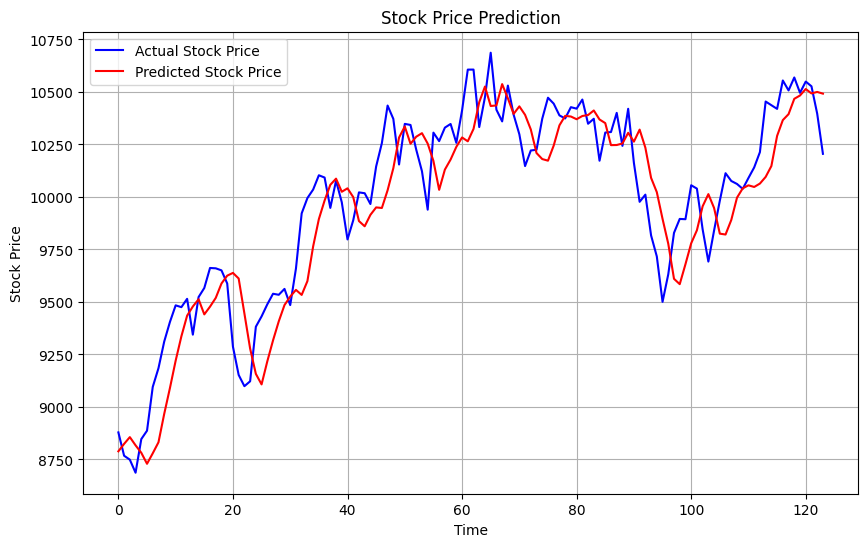

Root Mean Squared Error: 199.03867775834732
Mean Absolute Percentage Error: 0.016658917073311328


In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test['Close/Last'].values[seq_length+1:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")
